In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from glob import glob
import numpy as np
import pandas as pd
from librosa.core import resample, to_mono
from tqdm import tqdm
import wavio
import sys
#Add the path of the dir where is parameters.py 
sys.path.append( '../' )
import parameters 

In [2]:
src_root="../"+parameters.SRC_ROOT
dst_root=parameters.DST_ROOT
delta_time=parameters.DELTA_TIME
sr=parameters.SR

fn=parameters.FN
threshold=parameters.THRESHOLD

In [3]:
#Functions
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean


def downsample_mono(path, sr):
    obj = wavio.read(path)
    wav = obj.data.astype(np.float32, order='F')
    rate = obj.rate
    try:
        channel = wav.shape[1]
        if channel == 2:
            wav = to_mono(wav.T)
        elif channel == 1:
            wav = to_mono(wav.reshape(-1))
    except IndexError:
        wav = to_mono(wav.reshape(-1))
        pass
    except Exception as exc:
        raise exc
    wav = resample(wav, rate, sr)
    wav = wav.astype(np.int16)
    return sr, wav

In [4]:
#Goal is to find a method to autmatically find the best threshold for a recording
def Display_AVG_Useful_Record_Time():
    dt=delta_time
    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_paths = [x for x in wav_paths if '.wav' in x]
    dirs = os.listdir(src_root)
    classes = os.listdir(src_root)
    wav_before_mask=0
    wav_after_mask=0
    counter=0
    for _cls in classes:
        target_dir = os.path.join(dst_root, _cls)
        src_dir = os.path.join(src_root, _cls)
        for fn in tqdm(os.listdir(src_dir)):
            src_fn = os.path.join(src_dir, fn)
            rate, wav = downsample_mono(src_fn, sr)
            mask, y_mean = envelope(wav, rate, threshold=threshold)
            wav_before_mask=wav_before_mask + (len(wav)/sr)          
            wav = wav[mask]
            wav_after_mask=wav_after_mask + (len(wav)/sr)  
            counter=counter+1  
    print("Sur ",counter," échantillons")
    print("Durée moyenne avant masque : ",wav_before_mask/counter)
    print("Durée moyenne après masque :",wav_after_mask/counter)
#Display_AVG_Useful_Record_Time()

Display_AVG_Useful_Record_Time function gets arround 0.56s for a threshold of 500 (What I usually use to isolate words, I determined it by hand looking at different signals) so we can assume that the average time that the word un,deux,trois,quattre,oui,non takes arround 0.56s to say.

The goal now is to have a sliding window of a time duration that will sum up the amplitude of the signal audio on that window. In that way we will get an area, by moving that sliding window on the x axis (time) we will get areas for each x, then we will find the max of those area and store the x value corresponding at this maximum. The next step will be to get the max in amplitude in that sliding window and get a ratio (1/3 or 1/2) of that amplitude as a threshold. The last step would be removing all the parts under that threshold.

C:\Users\sabat\AppData\Local\Temp\ipykernel_12016\310424674.py:31: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  wav = resample(wav, rate, sr)


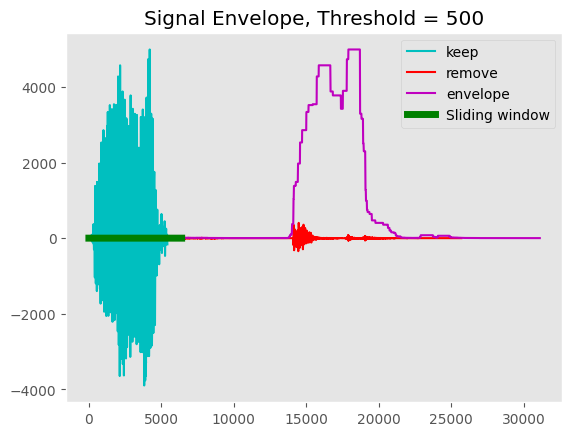

In [5]:
#Time of the sliding window in seconds
time_window=0.4
sliding_window=round(0.4*sr)
wav_paths = glob('{}/**'.format(src_root), recursive=True)
wav_path = [x for x in wav_paths if fn in x]

if len(wav_path) != 1:
    print('Could not find a file for sub-string: {}'.format(fn))
else:
    rate, wav = downsample_mono(wav_path[0], sr)
    mask, env = envelope(wav, rate, threshold=threshold)
    plt.style.use('ggplot')
    plt.title('Signal Envelope, Threshold = {}'.format(str(threshold)))
    plt.plot(wav[mask], color='c', label='keep')
    plt.plot(wav[np.logical_not(mask)], color='r', label='remove')
    plt.plot(env, color='m', label='envelope')
    plt.plot(np.zeros(sliding_window), color='g',linewidth=5, label='Sliding window')
    plt.grid(False)
    plt.legend(loc='best')
    plt.show()

We can see that the sliding window would be large enough to get the whole word. Now we need to get the area of under the sliding window.

C:\Users\sabat\AppData\Local\Temp\ipykernel_12016\310424674.py:31: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  wav = resample(wav, rate, sr)


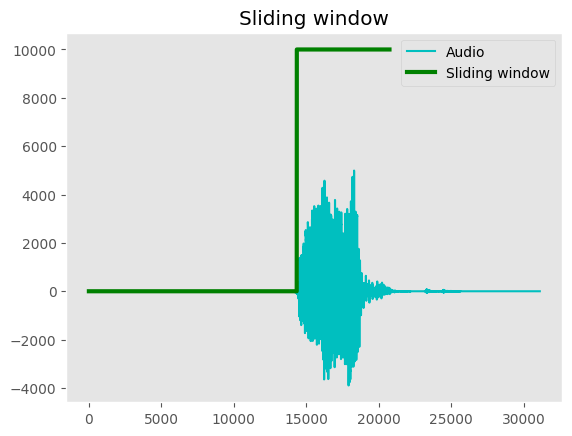

In [6]:
def get_area(wav,sliding_window,x):
    area=0
    if(sliding_window+x <= len(wav)):
        for indice in range(0,sliding_window):
            area=area+ abs(wav[x+indice])
    return area
    
def get_max_X_area(wav,sliding_window):
    max_X=0
    max_area=0
    for indice in np.arange(0,len(wav),round(sliding_window/50)):
        area=get_area(wav,sliding_window,indice)
        if(max_area<=area):
            max_area=area
            max_X=indice
    return max_X
rate, wav = downsample_mono(wav_path[0], sr)
plt.style.use('ggplot')
plt.title('Sliding window')
plt.plot(wav, color='c', label='Audio')
max_x=get_max_X_area(wav,sliding_window)
show_result=np.zeros(max_x)
for indice in range(1,sliding_window):
    show_result=np.append(show_result,10000)
plt.plot(show_result, color='g',linewidth=3, label='Sliding window')
plt.grid(False)
plt.legend(loc='best')
plt.show()

Here you can see that the sliding window is on top of the usefull signal and mitigate the risk of taking the noise in account.Now that we have the X and the sliding window we need to get the max value in that sliding window in amplitude and make it our reference for the threshold.

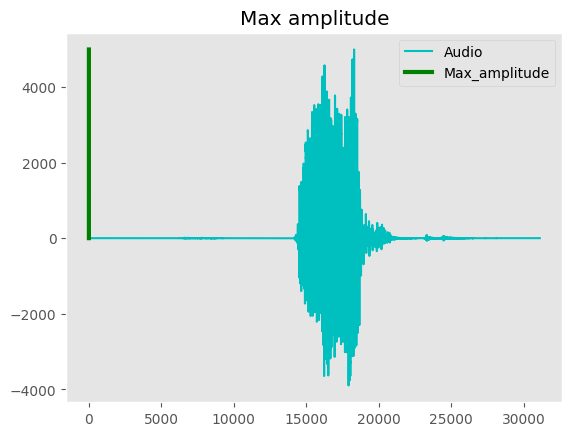

In [7]:
def get_max_amplitude(wav,sliding_window,x):
    max_y=0
    for indice in range(0,sliding_window):
        if max_y<abs(wav[x+indice]):
            max_y=abs(wav[x+indice])
    return int(max_y)
plt.style.use('ggplot')
plt.title('Max amplitude')
plt.plot(wav, color='c', label='Audio')
max_amplitude=get_max_amplitude(wav,sliding_window,max_x)
plt.plot([0,max_amplitude], color='g',linewidth=3, label='Max_amplitude')
plt.grid(False)
plt.legend(loc='best')
plt.show()

We can see that the max that we get the max on the Y axis that it's negative or positive. What is left is to determine a ratio that fit's most of the recordings.The max can be a noise close to the word and if the ratio taken is too big we may loose the audio part that we wanna keep the word. To solve that we can return 2 different max in the sliding window that are far enough from each other (as a noise that can disrupt the recording would be short and high amplitude). To do that we will put the condition that the 2 maxes_amplitude must be as far as 0.2 of the sliding_window.

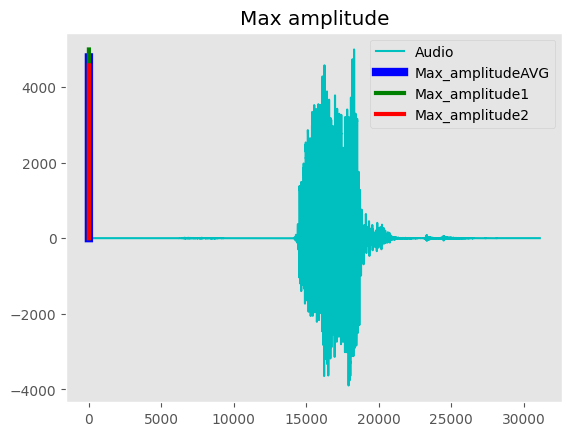

In [8]:
def get_maxes_amplitude(wav,sliding_window,x):
    max_y=0
    max_Y_X=0
    max_Y2=0
    for indice in range(0,sliding_window):
        if max_y<abs(wav[x+indice]):
            max_y=abs(wav[x+indice])
            max_Y_X=x+indice
    for indice in range(0,sliding_window):
        if max_Y2<abs(wav[x+indice]) and abs(max_Y_X-(x+indice))>sliding_window*0.2:
            max_Y2=abs(wav[x+indice])
    return int(max_y),int(max_Y2)

plt.style.use('ggplot')
plt.title('Max amplitude')
plt.plot(wav, color='c', label='Audio')
max_amplitude1,max_amplitude2=get_maxes_amplitude(wav,sliding_window,max_x)
max_avg_amplitude=(max_amplitude1+max_amplitude2)/2
plt.plot([0,max_avg_amplitude], color='b',linewidth=6, label='Max_amplitudeAVG')
plt.plot([0,max_amplitude1], color='g',linewidth=3, label='Max_amplitude1')
plt.plot([0,max_amplitude2], color='r',linewidth=3, label='Max_amplitude2')

plt.grid(False)
plt.legend(loc='best')
plt.show()

Now we have the threshold the AVG of the two max amplitude we can use a ratio of 1/3 of that amplitude to get the audio signal that is intersting in the .wav file.

C:\Users\sabat\AppData\Local\Temp\ipykernel_12016\310424674.py:31: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  wav = resample(wav, rate, sr)


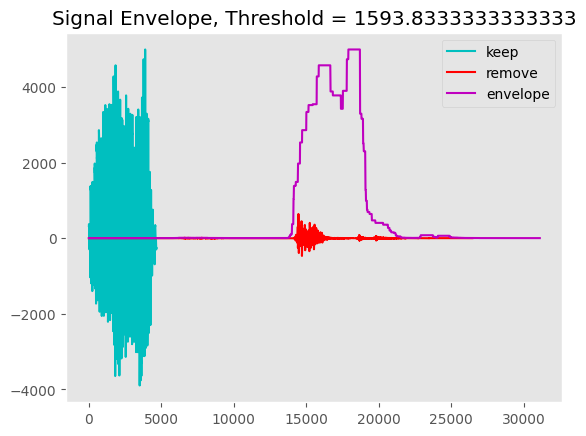

In [9]:
threshold=max_avg_amplitude/3
rate, wav = downsample_mono(wav_path[0], sr)
mask, env = envelope(wav, rate, threshold=threshold)
plt.style.use('ggplot')
plt.title('Signal Envelope, Threshold = {}'.format(str(threshold)))
plt.plot(wav[mask], color='c', label='keep')
plt.plot(wav[np.logical_not(mask)], color='r', label='remove')
plt.plot(env, color='m', label='envelope')
plt.grid(False)
plt.legend(loc='best')
plt.show()